## Spam Classifier   
#### In this notebook, I am going to prepare a complete machine learning pipeline, from data downloading to model comparison and tuning.  
#### Enjoy your read!

In [1]:
import tarfile
import email.parser
import email.policy
import os
import re
import warnings
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from urllib.request import urlretrieve
from html2text import html2text
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier

warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

## 1. Data processing

Let's start with some data engineering work. The pipeline will start by downloading files and extracting them as email message objects.

In [ ]:
url = 'https://spamassassin.apache.org/old/publiccorpus/'
files = ('20030228_easy_ham.tar.bz2', '20030228_spam.tar.bz2')
for filename in files:
    urlretrieve(os.path.join(url, filename), filename)
    tar = tarfile.open(filename)
    x = tar.extractall()
    tar.close()

In [2]:
def extract_emails(dirname):
    emails = []
    for filename in os.listdir(dirname):
        file = os.path.join(dirname, filename)
        if os.path.isfile(file):
            with open(file, "rb") as f:
                emails.append(email.parser.BytesParser(policy=email.policy.default).parse(f))
    return emails

In [3]:
spam = extract_emails('spam')
ham = extract_emails('easy_ham')

Take a look at an example of parsed email:

In [4]:
print(spam[0])

Return-Path: <12a1mailbot1@web.de>
Delivered-To: zzzz@localhost.spamassassin.taint.org
Received: from localhost (localhost [127.0.0.1])
	by phobos.labs.spamassassin.taint.org (Postfix) with ESMTP id 136B943C32
	for <zzzz@localhost>; Thu, 22 Aug 2002 08:17:21 -0400 (EDT)
Received: from mail.webnote.net [193.120.211.219]
	by localhost with POP3 (fetchmail-5.9.0)
	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 13:17:21 +0100 (IST)
Received: from dd_it7 ([210.97.77.167])
	by webnote.net (8.9.3/8.9.3) with ESMTP id NAA04623
	for <zzzz@spamassassin.taint.org>; Thu, 22 Aug 2002 13:09:41 +0100
From: 12a1mailbot1@web.de
Received: from r-smtp.korea.com - 203.122.2.197 by dd_it7  with Microsoft
 SMTPSVC(5.5.1775.675.6);	 Sat, 24 Aug 2002 09:42:10 +0900
To: <dcek1a1@netsgo.com>
Subject: Life Insurance - Why Pay More?
Date: Wed, 21 Aug 2002 20:31:57 -1600
MIME-Version: 1.0
Message-ID: <0103c1042001882DD_IT7@dd_it7>
Content-Type: text/html; charset="iso-8859-1"
Content-Transfer-Encoding: quoted-

We have 501 spam and 2501 ham (non-spam) emails.

In [5]:
print(f"number of spam emails: {len(spam)}")
print(f"number of ham emails: {len(ham)}")

number of spam emails: 501
number of ham emails: 2501


It's necessary to convert this raw metadata to what's interests us the most - content written by the sender.

In [6]:
def convert_to_text(email_):
    content = ""
    if isinstance(email_.get_payload(), list):
        for payload in email_.get_payload():
            content += convert_to_text(payload)
        return content
    else:
        try: #to avoid encoding errors
            return html2text(email_.get_content())
        except:
            return ""

spam = list(map(convert_to_text, spam))
ham = list(map(convert_to_text, ham))

I decided to get rid of every character in emails except of some predefined set consisting of alphanumeric chars, 
'@', '.', '/', ':', and ' '. I replaced them with white space, then changed every multiple white spaces to one white space and stripped all emails. I also removed newline characters from the string, as they aren't useful for analysis.


In [7]:
def filter_email(email_):
    converted_email = re.sub('\n', ' ', email_)
    converted_email = re.sub('[^0-9a-zA-Z@./:]', ' ', email_)
    converted_email = re.sub(' +', ' ', converted_email)
    converted_email = converted_email.strip().lower()
    return converted_email

spam = list(map(filter_email, spam))
ham = list(map(filter_email, ham))

Now, example of an email looks like this:

In [31]:
print(spam[0])

save up to 70 on life insurance. why spend more than you have to life quote savings ensuring your family s financial security is very important. life quote savings makes buying life insurance simple and affordable. we provide free access to the very best companies and the lowest rates. life quote savings is fast easy and saves you money let us help you get started with the best values in the country on new coverage. you can save hundreds or even thousands of dollars by requesting a free quote from lifequote savings. our service will take you less than 5 minutes to complete. shop and compare. save up to 70 on all types of life insurance click here for your free quote http://website.e365.cc/savequote/ protecting your family is the best investment you ll ever make if you are in receipt of this email in error and/or wish to be removed from our list please click here mailto:coins@btamail.net.cn and type remove. if you reside in any state which prohibits e mail solicitations for insurance pl

Exception handling during email conversion may have resulted in some empty emails in our dataset. Fortunately, there are only 5 emails like this, so we can just erase them from the dataset

In [8]:
def count_empty_emails(emails):
    count = 0
    for i, email_ in enumerate(emails):
        if email_ == "":
           count += 1
    return count

empty_spam = count_empty_emails(spam)
empty_ham = count_empty_emails(ham)
print(f"spam: {empty_spam}, ham: {empty_ham}")

spam = [email for email in spam if email] #remove empty strings
            
            
    

spam: 5, ham: 0


We're now entering the final phase of the processing of the dataset. Our next step involves identifying the most frequently occurring words in the spam emails. Following that, we'll construct a labeled dataframe where each column corresponds to a specific word, and the value in each cell indicates the frequency of that word in a particular email. This structured approach will enable us to effectively analyze the dataset and extract valuable insights.

In [9]:
def find_words_occurrence_number(emails):
    words = Counter()
    for email_ in emails:
        words.update(email_.split())
    return words
    
def filter_to_most_occurring(words):
    return {w:k for (w,k) in words.items() if k > 100 and len(w) > 3}
             
spam_words = find_words_occurrence_number(spam)
spam_words = filter_to_most_occurring(spam_words)
             


Class labels:  
1 - spam  
0 - ham  

In [10]:
def find_match_count(word: str, pattern: str) -> int:
    return len(re.findall(pattern, word.lower()))

spam_df = pd.DataFrame({'email_': spam})
for col in spam_words:
    spam_df[col] = spam_df['email_'].apply(find_match_count, pattern=col)
spam_df['label'] = 1
spam_df = spam_df.drop('email_', axis=1)

In [11]:
ham_df = pd.DataFrame({'email_': ham}) 
for col in spam_words:
    ham_df[col] = ham_df['email_'].apply(lambda x: x.count(col))
ham_df['label'] = 0
ham_df = ham_df.drop('email_', axis=1)

Ultimately, we concats our spam and ham datasets and shuffle the new dataset.

In [12]:
df = pd.concat([spam_df, ham_df], ignore_index=True)
df = df.sample(frac=1).reset_index(drop=True)

So, this is the final dataset. It consists of 2997 rows, each coresponding to one email, and 140 columns, each coresponding to one of the most occurring words in spam emails. The numbers are occurrences of these words in specific emails.

In [13]:
df

,save,life,more,than,have,your,financial,very,insurance,simple,...,mails,well,before,after,orders,income,guide,enenkio,grants,label
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
1,0,0,0,0,1,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,6,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2992,0,0,0,0,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2993,1,0,0,1,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2994,0,3,0,1,6,3,0,2,0,0,...,0,0,0,2,0,0,1,0,0,0
2995,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 2. ML Models comparison

It's finally time to start analytical work. We will try to maximize the accuracy of our predictions by looking for the best among four different classifiers: stochastic gradient, K-nearest neighbors, random forests and gradient boosting as I think of them as the most suitable for this task.


Firstly, we will divide our dataset into test and train data.

In [14]:
y = df["label"]
X = df.drop("label", axis=1)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

The classifiers will be compared according to four distinct metrics: accuracy, spam detecting accuracy, F1 score and ROC AUC score. We have around 2250 samples in training set and around 750 samples in test set. Unfortunately, the spam/ham ratio is 1/5 which may cause some problems, so that we will carefully look not only at the general model accuracy, but also spam accuracy, which is a ratio of detected spam to all spam emails.

In [16]:
def spam_ham_accuracy(confusion_matrix):
    spam_accuracy = confusion_matrix[0, 0] / (confusion_matrix[0, 1] + confusion_matrix[0, 0])
    ham_accuracy = confusion_matrix[1, 1] / (confusion_matrix[1, 1] + confusion_matrix[1, 0])
    return spam_accuracy, ham_accuracy

In [17]:
def evaluate_model(model):
    y_predict = model.predict(X_test)
    conf_matrix = confusion_matrix(y_test, y_predict, labels=(1,0))
    print(model.__class__.__name__)
    print()
    print("confusion_matrix:")
    print(conf_matrix)
    accuracy = accuracy_score(y_test, y_predict)
    print(f"general accuracy: {accuracy}")
    spam_accuracy, ham_accuracy = spam_ham_accuracy(conf_matrix)
    print(f"spam_accuracy: {spam_accuracy}")
    f1 = f1_score(y_test, y_predict)
    print(f"f1_score: {f1}")
    roc_auc = roc_auc_score(y_test, y_predict)
    print(f"roc_auc_score: {roc_auc}")
    metrics[model.__class__.__name__] = [accuracy, spam_accuracy, f1, roc_auc]
    return model, y_predict

You can look at the values of metrics of every classifier individually or at the comparison below the training code.

In [18]:
metrics = {}

In [19]:
sgd = SGDClassifier(loss='log_loss')
sgd.fit(X_train, y_train)
sgd_scores = cross_val_predict(sgd, X_train, y_train, cv=3, method='predict_proba')
sgd, sgd_predict = evaluate_model(sgd)

SGDClassifier
confusion_matrix: 

[[114   5]
 [  3 628]]
general accuracy: 0.9893333333333333
spam_accuracy: 0.957983193277311
f1_score: 0.9661016949152542
roc_auc_score: 0.9766144175578315


In [20]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
knn_scores = cross_val_predict(sgd, X_train, y_train, cv=3, method='predict_proba')
knn, knn_predict= evaluate_model(knn)

KNeighborsClassifier
confusion_matrix: 

[[105  14]
 [  5 626]]
general accuracy: 0.9746666666666667
spam_accuracy: 0.8823529411764706
f1_score: 0.9170305676855895
roc_auc_score: 0.9372145054535285


In [21]:
gbc = GradientBoostingClassifier()
gbc.fit(X_train, y_train)
gbc_scores = cross_val_predict(sgd, X_train, y_train, cv=3, method='predict_proba')
gbc, gbc_predict = evaluate_model(gbc)

GradientBoostingClassifier
confusion_matrix: 

[[114   5]
 [  2 629]]
general accuracy: 0.9906666666666667
spam_accuracy: 0.957983193277311
f1_score: 0.9702127659574468
roc_auc_score: 0.9774068105847727


In [22]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
rfc_scores = cross_val_predict(sgd, X_train, y_train, cv=3, method='predict_proba')
rfc, rfc_predict = evaluate_model(rfc)

RandomForestClassifier
confusion_matrix: 

[[116   3]
 [  2 629]]
general accuracy: 0.9933333333333333
spam_accuracy: 0.9747899159663865
f1_score: 0.9789029535864979
roc_auc_score: 0.9858101719293105


Comparison of the performance of our models:

In [32]:
metrics = pd.DataFrame(metrics, index=['accuracy', 'spam_accuracy', 'F1 score', 'ROC AUC score'])
metrics

,SGDClassifier,KNeighborsClassifier,GradientBoostingClassifier,RandomForestClassifier,TunedRandomForest
accuracy,0.989333,0.974667,0.990667,0.993333,0.994667
spam_accuracy,0.957983,0.882353,0.957983,0.974790,0.983193
F1 score,0.966102,0.917031,0.970213,0.978903,0.983193
ROC AUC score,0.976614,0.937215,0.977407,0.985810,0.990012


Here is also comparison of the ROC Curve of every classifier:

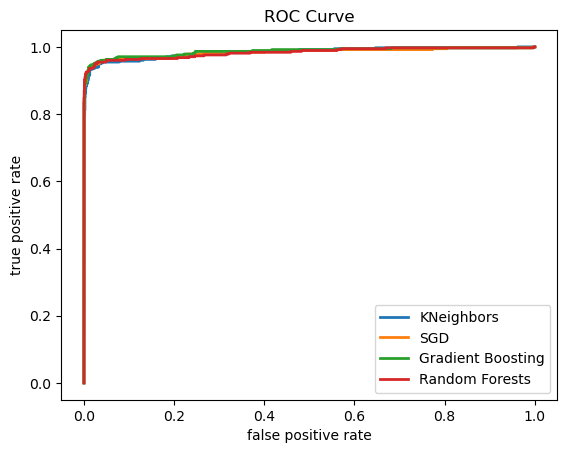

In [23]:
def plot_roc_curve(y_scores, name):
  fpr, tpr, thresholds = roc_curve(y_train, y_scores)
  plt.title('ROC Curve')
  plt.plot(fpr, tpr, linewidth=2, label=name)
  plt.xlabel('false positive rate')
  plt.ylabel('true positive rate')

plot_roc_curve(knn_scores[:, 1], 'KNeighbors')
plot_roc_curve(gbc_scores[:, 1], 'SGD')
plot_roc_curve(sgd_scores[:, 1], 'Gradient Boosting')
plot_roc_curve(rfc_scores[:, 1], 'Random Forests')
plt.legend()
plt.show()

If you like visualizations more than raw numbers - you can draw your conclusions basing on the plot:

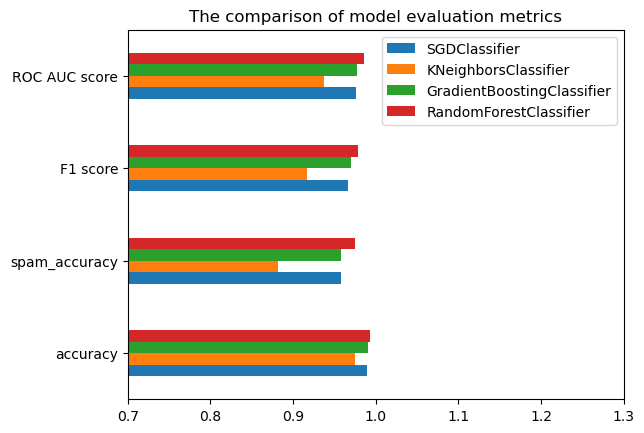

In [25]:
def plot_models():
    metrics.plot(kind='barh')
    plt.title("The comparison of model evaluation metrics")
    plt.xlim(0.7, 1.3)
    plt.show()
plot_models()

To sum up, it's not so easy to say which classifier performs the best in this specified task. In fact, if you run this notebook few times, your results may differ a bit after every try. 

What we can conclude, the KNeighborsClassifier works really bad, compared to three other classifiers. Either Gradient Boosting, SGD and Random Forest Classifier detects around 92-96% percent of spam emails, which I believe to be decent performance. The choice between one of these tree doesn't seem to make a real difference.

## 3. Model tuning

The analysis could end here, but we will make the last try to improve the accuracy of our spam detector. Random forest is commonly known as a model which may be significantly improved by parameter tuning. Grid search would work for ages with this number of parameters, so the randomized search seems to be the best for this problem, with the iteration limit set to 100.

In [ ]:
def tune_RF():
    model = RandomForestClassifier()
    parameters = {'bootstrap': [True, False],
                  'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
                  'max_features': ['auto', 'sqrt'],
                  'min_samples_leaf': [1, 2, 4],
                  'min_samples_split': [2, 5, 10],
                  'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}
    model = RandomizedSearchCV(estimator=model, param_distributions=parameters,
        n_iter=100, cv=3, n_jobs=-1, verbose=2)
    model.fit(X_train, y_train)
    return model

In [27]:
model = tune_RF()

Fitting 3 folds for each of 100 candidates, totalling 300 fits


As we can see below, randomized search performed wonderfully in this case, improving the performance of our model to over 98% spam detection accuracy! It seems to be an outstanding result.

In [28]:
tuned_rf, tuned_rf_predict = evaluate_model(model)

RandomizedSearchCV
confusion_matrix: 

[[117   2]
 [  2 629]]
general accuracy: 0.9946666666666667
spam_accuracy: 0.9831932773109243
f1_score: 0.9831932773109243
roc_auc_score: 0.9900118526015794


Below you can look at the best, found by randomized search algorithm, random forest parameters. 

In [29]:
model.best_params_

{'n_estimators': 2000,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 90,
 'bootstrap': False}

## 4. Summary

I also extended the plot of model's performance to include the tuned random forest:

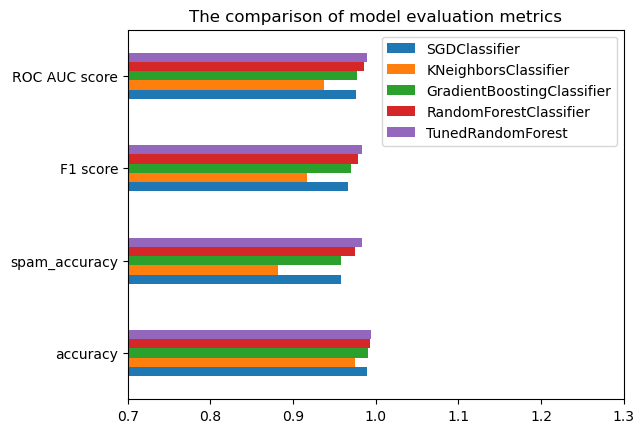

In [30]:
metrics = metrics.rename({"RandomizedSearchCV": "TunedRandomForest"}, axis=1)
plot_models()

In conclusion, we've developed machine learning models capable of identifying spam emails with an accuracy ranging from 92% to 98%. Determining the superior classifier among SGD, Gradient Boosting, and Random Forest is challenging, as they all exhibit strong performance and yield comparable metric values. However, random forest model tuning resulted in visible increase of performance and it seems to work the best among compared classifiers. Worth emphasizing, KNearestNeighbors surely looks like really poor model for spam classification.

I really appreciate your time spent reviewing this notebook. Thank you!